In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')


print(tf.__version__)

2.18.0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
class CONFIG:
    DATA_PATH = '../data/archive'
    TEST_FEATURES = 'csvTestImages 3360x1024.csv'
    TRAIN_FEATURES = 'csvTrainImages 13440x1024.csv'
    TEST_LABELS = 'csvTestLabel 3360x1.csv' 
    TRAIN_LABELS = 'csvTrainLabel 13440x1.csv'
    IMAGE_SIZE = 32
    

In [5]:
train_features = pd.read_csv(f'{CONFIG.DATA_PATH}/{CONFIG.TRAIN_FEATURES}', header=None)
train_labels = pd.read_csv(f'{CONFIG.DATA_PATH}/{CONFIG.TRAIN_LABELS}', header=None)
test_features = pd.read_csv(f'{CONFIG.DATA_PATH}/{CONFIG.TEST_FEATURES}',   header=None)
test_labels = pd.read_csv(f'{CONFIG.DATA_PATH}/{CONFIG.TEST_LABELS}', header=None)

In [6]:
print(f'train_features: {train_features.shape}')
print(f'train_labels: {train_labels.shape}')
print(f'test_features: {test_features.shape}')
print(f'test_labels: {test_labels.shape}')

train_features: (13440, 1024)
train_labels: (13440, 1)
test_features: (3360, 1024)
test_labels: (3360, 1)


In [7]:
train_labels.columns = ['label']
test_labels.columns = ['label']

In [8]:
train = pd.concat([train_features, train_labels], axis=1)
test = pd.concat([test_features, test_labels], axis=1)


In [9]:
train["label"].nunique()

28

In [10]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
train["label"] = train["label"] -1
test["label"] = test["label"] -1

In [12]:
arabics_chars = ['alef','beh','teh','theh','jeem','hah','khah','dal','thal','reh','zain',
                 'seen','sheen','sad','dad','tah','zah','ain','ghain','feh','qaf','kaf','lam','meem','noon','heh','waw','yeh']

index_to_char = {i:char for i, char in enumerate(arabics_chars)}
char_to_index = {char:i for i, char in enumerate(arabics_chars)}

In [13]:
index_to_char[0]

'alef'

In [14]:
train_images = train.iloc[:, :-1].values.reshape(-1, 32, 32, 1).astype('float32') / 255.0
test_images = test.iloc[:, :-1].values.reshape(-1, 32, 32,1).astype('float32') / 255.0

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train.iloc[:,-1].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test.iloc[:,-1].values))


In [16]:
for item in train_dataset.take(1):
    print(item[0].shape)
    print(item[1].shape)

(32, 32, 1)
()


In [17]:
samples  = train_dataset.take(6)

In [18]:
for item in train_dataset.take(1):
    print(item[0].shape)
    print(item[1].shape)

(32, 32, 1)
()


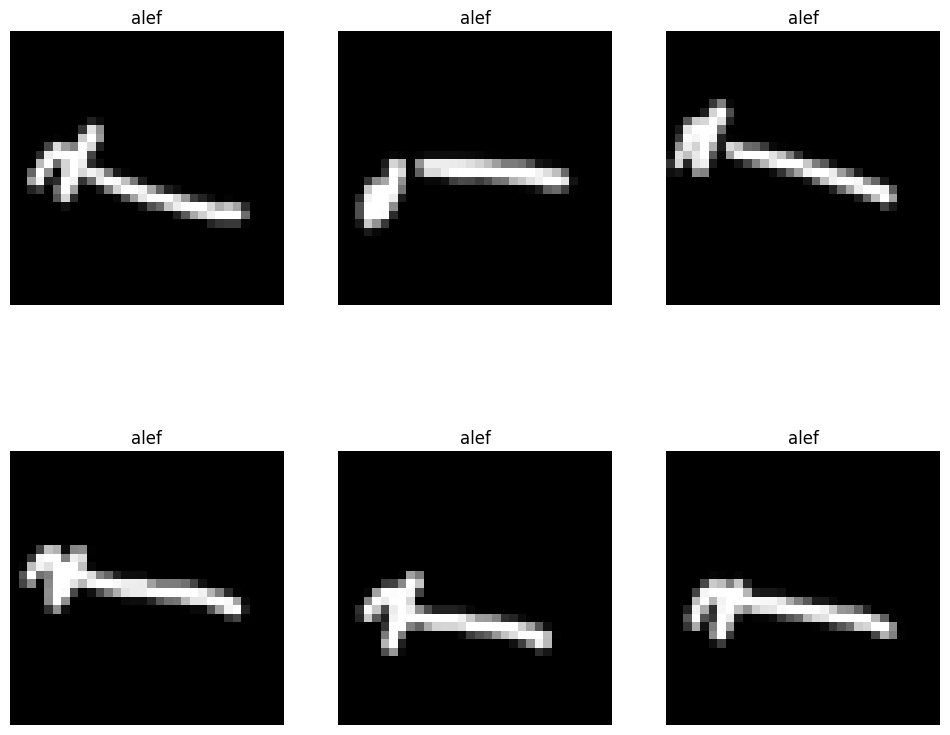

In [19]:
def plot_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(index_to_char[label.numpy()])
    plt.axis("off")

plt.figure(figsize=(12, 10))
for i, (image, label) in enumerate(samples):
    plt.subplot(2, 3, i+1)
    plot_image(image.numpy(), label)

In [20]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
test_dataset = test_dataset.batch(32)

In [31]:
tf.keras.backend.clear_session()

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,164 (481.11 KB)

 Trainable params: 123,164 (481.11 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset,validation_data=test_dataset, epochs=25, callbacks=[early_stopping, model_checkpoint])

Epoch 1/25


420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3219 - loss: 2.2694

420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3223 - loss: 2.2678 - val_accuracy: 0.7131 - val_loss: 0.8829
Epoch 2/25
418/420 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7283 - loss: 0.8096

420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7287 - loss: 0.8084 - val_accuracy: 0.7857 - val_loss: 0.6326
Epoch 3/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8282 - loss: 0.5113

420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8283 - loss: 0.5111 - val_accuracy: 0.8464 - val_loss: 0.4782
Epoch 4/25
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8707 - loss: 0.3782

420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8708 - loss: 0.3779 - val_accuracy: 0.8643 - val_loss: 0.4512
Epoch 5/25
419/420 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8949 - loss: 0.3072

420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8950 - loss: 0.3069 - val_accuracy: 0.8815 - val_loss: 0.3858
Epoch 6/25
417/420 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9207 - loss: 0.2450

420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9208 - loss: 0.2446 - val_accuracy: 0.8940 - val_loss: 0.3777
Epoch 7/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9400 - loss: 0.1801 - val_accuracy: 0.8884 - val_loss: 0.3849
Epoch 8/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9463 - loss: 0.1586

420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9463 - loss: 0.1585 - val_accuracy: 0.9068 - val_loss: 0.3432
Epoch 9/25
418/420 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9604 - loss: 0.1147

420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9605 - loss: 0.1147 - val_accuracy: 0.9190 - val_loss: 0.3081
Epoch 10/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9630 - loss: 0.1068 - val_accuracy: 0.9119 - val_loss: 0.3281
Epoch 11/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9685 - loss: 0.1010 - val_accuracy: 0.9134 - val_loss: 0.3999
Epoch 12/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9697 - loss: 0.0895 - val_accuracy: 0.9054 - val_loss: 0.3586
Epoch 13/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9747 - loss: 0.0734 - val_accuracy: 0.9152 - val_loss: 0.3494
Epoch 14/25
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9742 - loss: 0.0739 - val_accuracy: 0.9173 - val_loss: 0.3613


<Axes: >

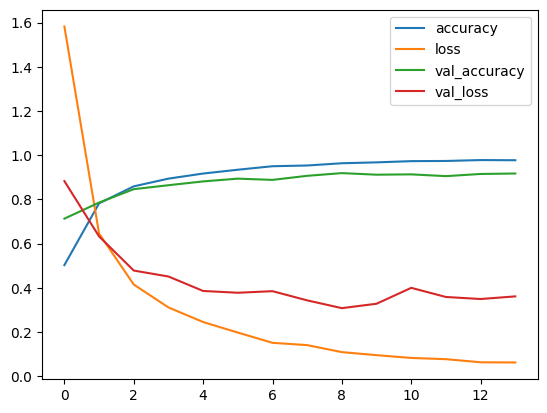

In [36]:
df_history = pd.DataFrame(history.history)
df_history.plot()


In [50]:
def show_feature_map(img, layer_index, model):
    
    inputs = model.inputs
    outputs = model.layers[layer_index].output
    feature_extractor = Model(inputs=inputs, outputs=outputs)
    
    # Get feature maps
    feature_maps = feature_extractor.predict(img)
    
    # Plot feature maps
    num_maps = feature_maps.shape[-1]
    grid_size = int(np.ceil(np.sqrt(num_maps)))
    
    plt.figure(figsize=(15, 15))
    for i in range(num_maps):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')
    
    plt.suptitle(f'Feature Maps from Layer {layer_index}', fontsize=16)
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


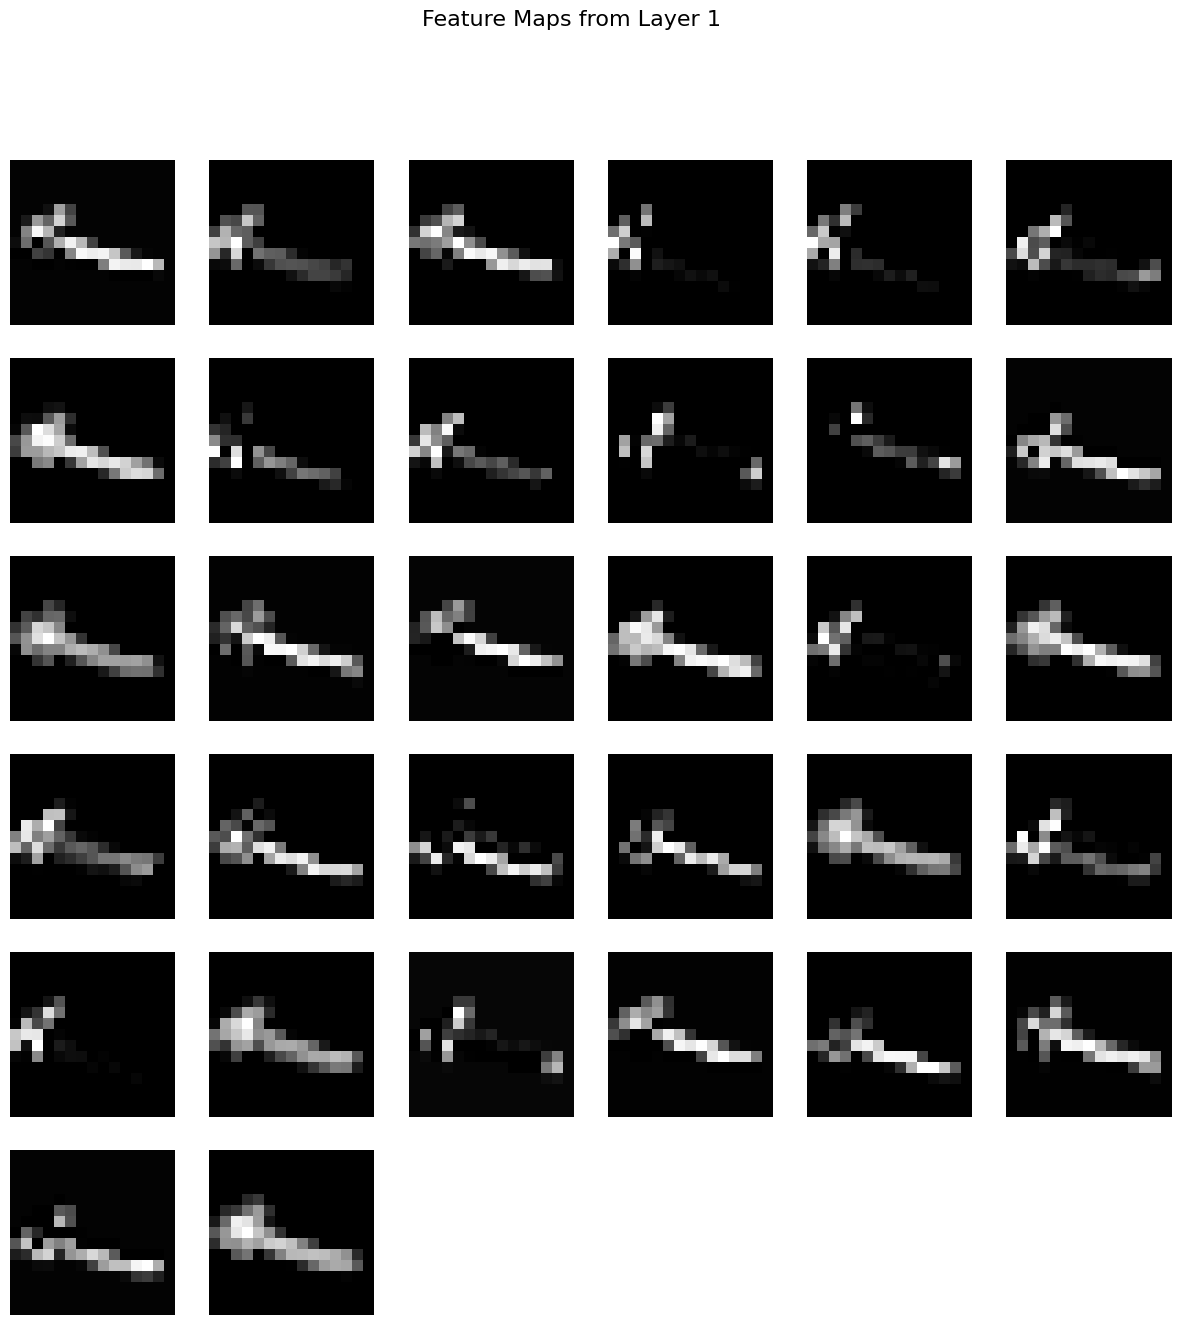

In [51]:
img = train_images[0].reshape(1, 32, 32, 1)
show_feature_map(img, 1, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


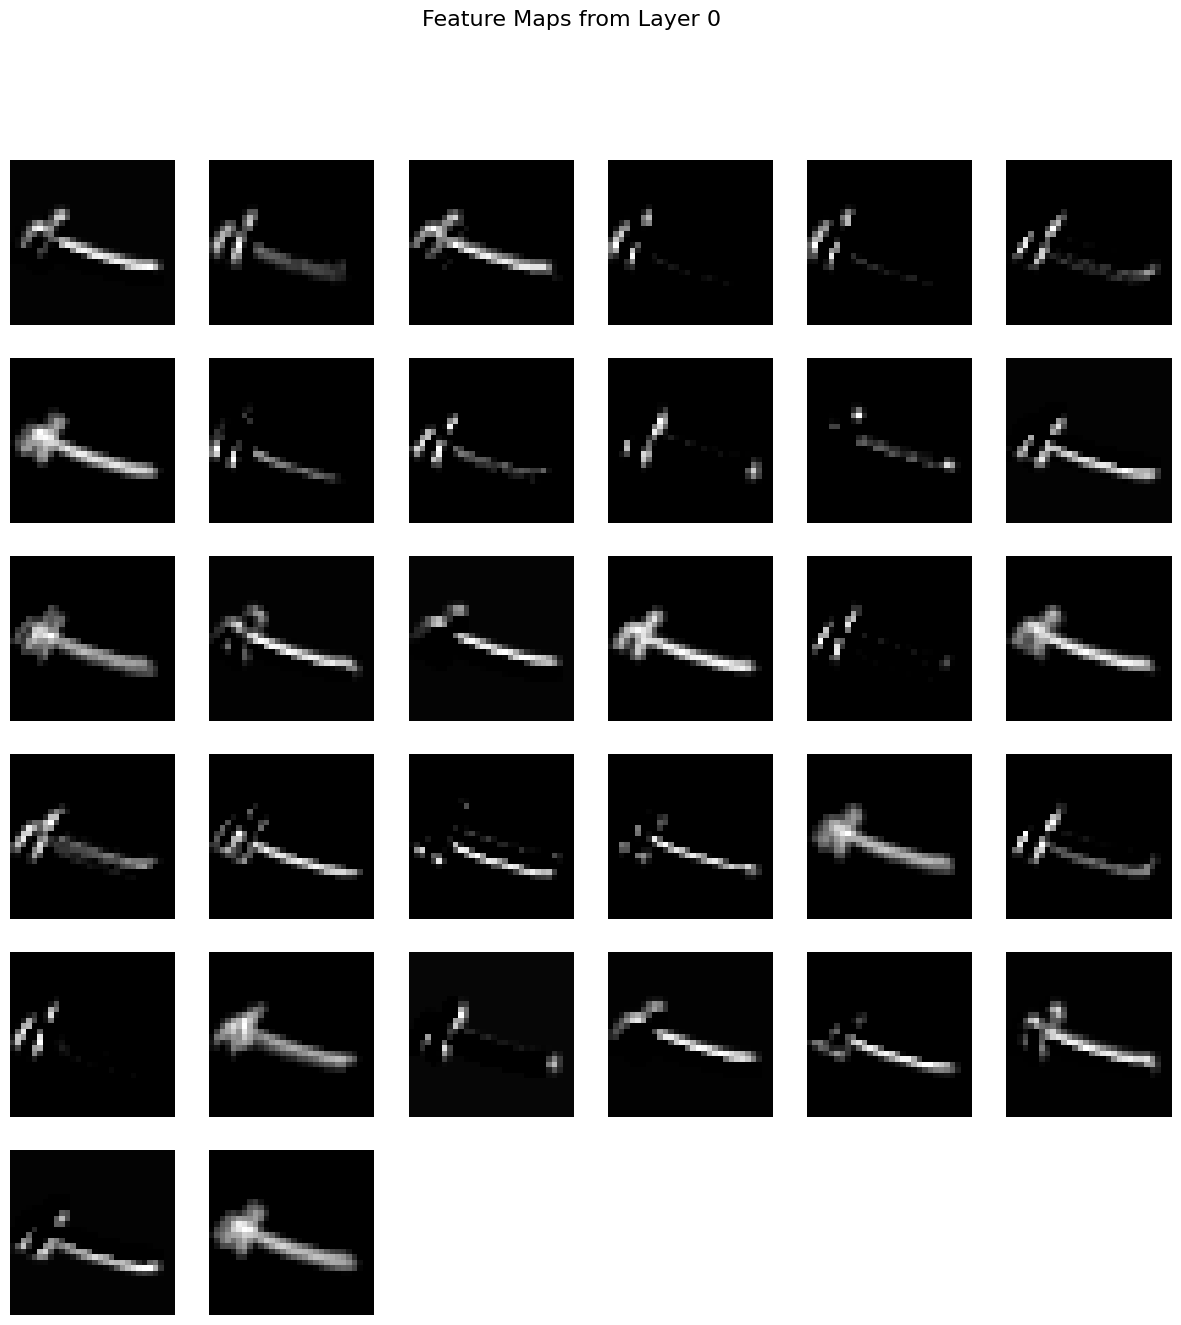

In [52]:
show_feature_map(img, 0, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


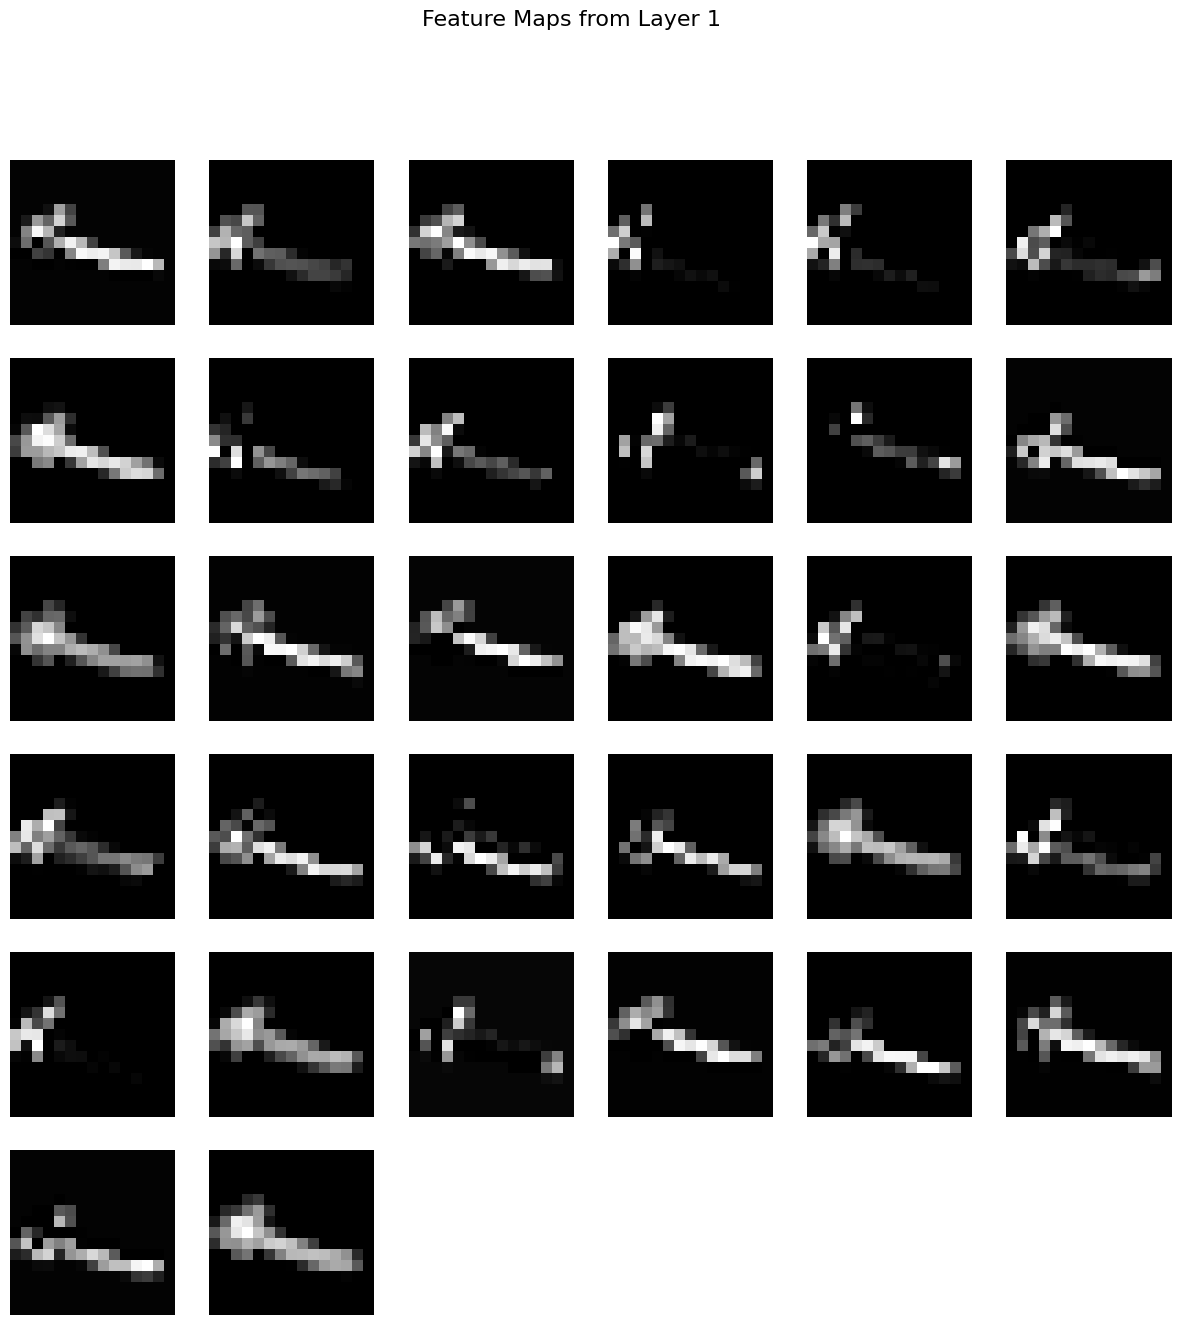

In [53]:
show_feature_map(img, 1, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


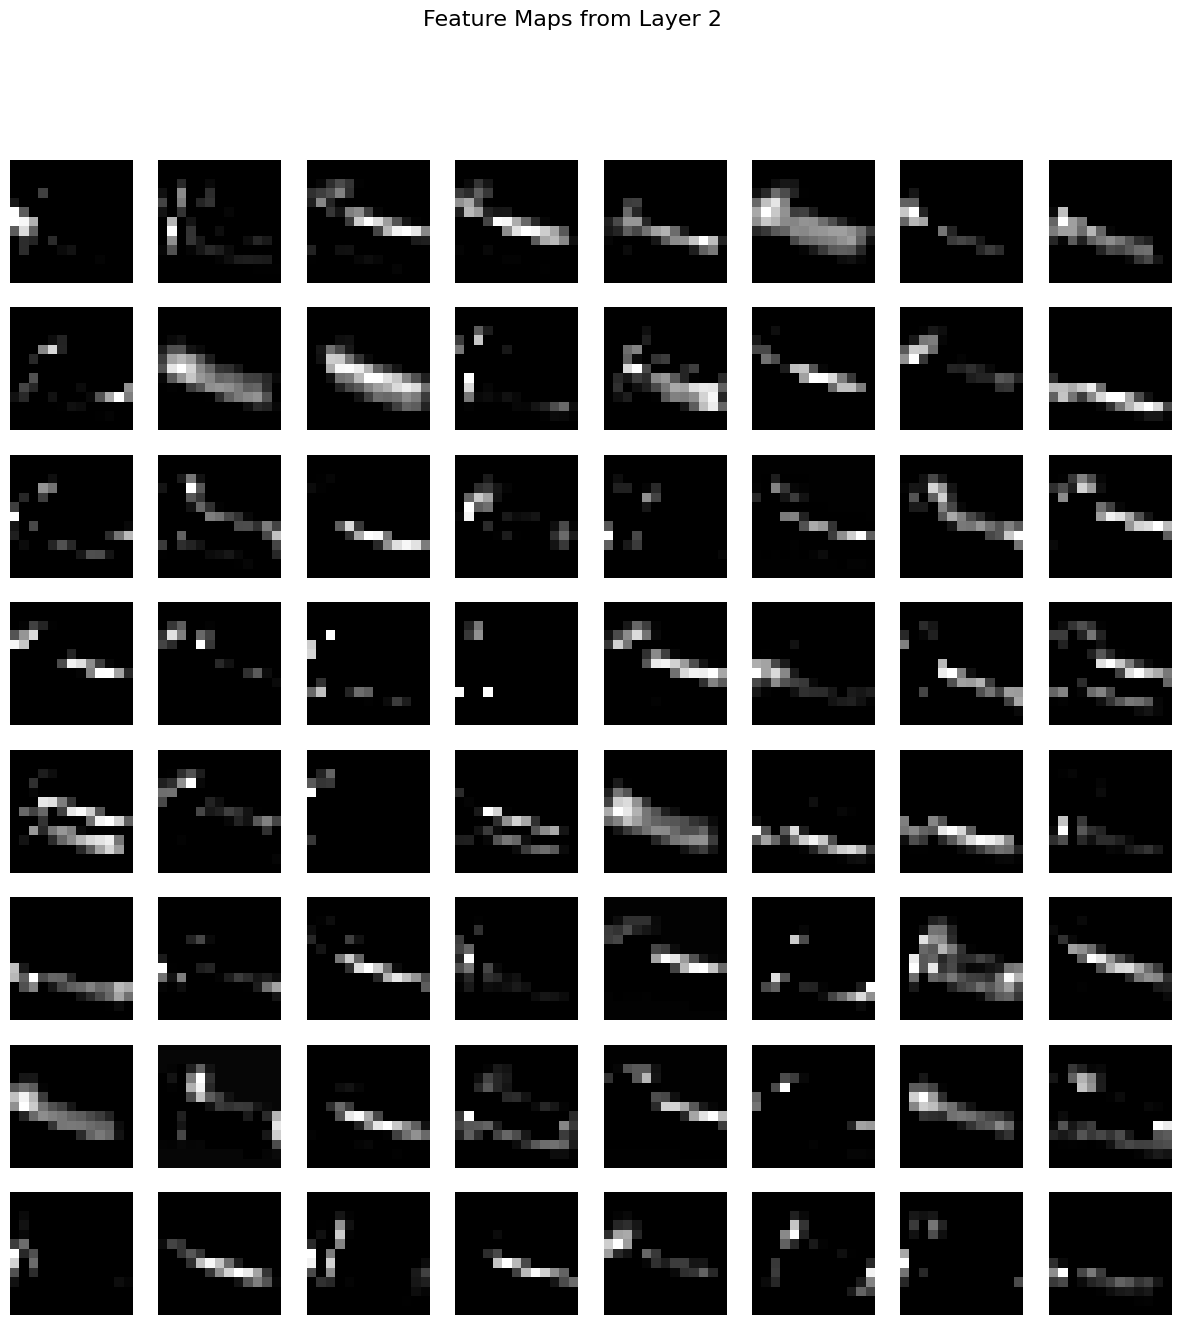

In [54]:
show_feature_map(img, 2, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


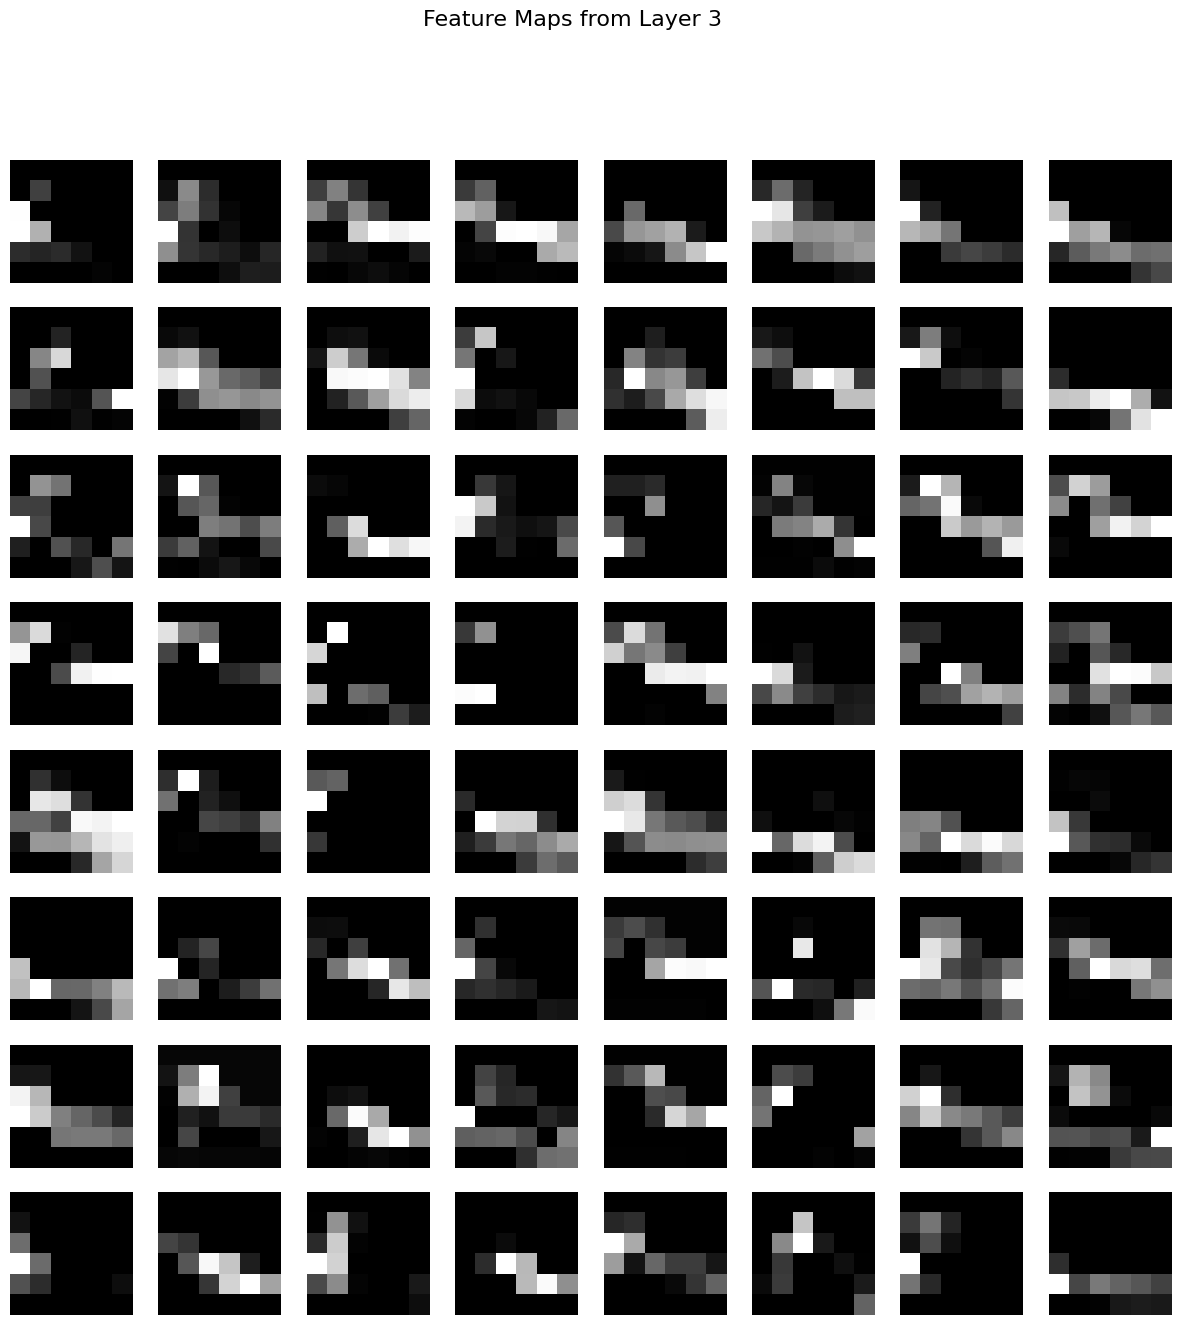

In [55]:
show_feature_map(img, 3, model)